# Sentencing

In [1]:
# This Python file uses the following encoding: utf-8
import os
from lib.words import not_so_naive_split, replace_evil_dots_and_underscores, tokenize_doc
from lib.parallel_run import parallel_run, parallelize
import numpy as np
import codecs

Divisione del testo in frasi, rimozione di stop words, numeri, punteggiatura...

In [5]:
# Esempio di split

t = not_so_naive_split(text, split='.')
#t

In [2]:
# old, no utf-8...
def sentence_splitting(src_dir, out_dir, digit_replacement='NUM', split='.', min_words=2, max_n=-1):
    i = 0
    for f in os.listdir(src_dir):
        txt = open(src_dir+'/'+f).read()
        splitted = not_so_naive_split(txt, digit_replacement, split, min_words)
        with open(out_dir+'/'+f, 'w') as of:
            for l in splitted:
                of.write(' '.join(l)+'\n')
        if max_n>0 and i >= max_n:
            break
        i += 1
        
def sentence_tokenize_file(f, src_dir, out_dir, min_words=2):
    txt = open(src_dir+'/'+f).read()
    splitted = tokenize_doc(txt, min_words)
    with codecs.open(out_dir+'/'+f, 'w', 'utf-8') as of:
        for l in splitted:
            of.write(u' '.join(l)+u'\n')
        
def sentence_tokenization(src_dir, out_dir, min_words=2):
    parallelize(sentence_tokenize_file)(os.listdir(src_dir), src_dir, out_dir, min_words)

In [3]:
# Per atti costitutivi
#sentence_splitting('../atti_costitutivi_txt','../atti_costitutivi_sentences')
sentence_tokenization('../atti_costitutivi_txt','../atti_costitutivi_sentences')

In [3]:
# Per atti non costitutivi
#sentence_splitting('../atti_non_costitutivi_txt2','../atti_non_costitutivi_sentences')
sentence_tokenization('../atti_non_costitutivi_txt','../atti_non_costitutivi_sentences')

In [3]:
# Per verbali
sentence_tokenization('../verbali_a05_txt/','../verbali_a05_sentences/')

In [4]:
# Per atti non costitutivi scansionati
sentence_splitting('../ocr/scanned_non_costitutivi','../atti_non_costitutivi_sentences')

In [3]:
# Esempio di testo elaborato

text = open('../atti_non_costitutivi_sentences/'+'4578843770001.txt').read()
print text

## Conversione in CSV

In [5]:
def folders_to_csv(csv_file, dirs, labels):
    '''
    Writes to a csv file the lines contained in a list of directories,
    assuming each directory is associated to one label'''
    with codecs.open(csv_file,'w', 'utf-8') as out_file:
        out_file.write('filename,sentence,label\n')
        for d, label in zip(dirs, labels):
            for f in os.listdir(d):
                with codecs.open(d+u'/'+f, 'r', 'utf-8') as in_file:
                    for line in in_file:
                        out_file.write((u','.join([f[:-4],line.strip(),label]))+u'\n')
 

In [6]:
folders_to_csv('../atti2.csv', ['../atti_costitutivi_sentences/','../atti_non_costitutivi_sentences/','../verbali_a05_sentences/'],['costitutivo','non_costitutivo','non_costitutivo'])

## Statistiche PANDAS

In [54]:
import pandas as pd
from matplotlib import pyplot as plt

In [55]:
def print_column_stats(col):
    print 'Mean', col.mean()
    print 'Stddev', col.std()
    print 'Min', col.min()
    print 'Max', col.max()

In [56]:
df = pd.read_csv("../atti2.csv", encoding='utf-8')
#df

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [57]:
df

,filename,sentence,label
0,5049618730001,repertorio n NUM raccolta n NUM atto costituti...,costitutivo
1,5049618730001,codice fiscale bnd dnl ALPHANUM ALPHANUM detto...,costitutivo
2,5049618730001,i e costituita società responsabilità limitata...,costitutivo
3,5049618730001,ii la sede società fissata comune modena,costitutivo
4,5049618730001,ai soli fini iscrizione registro imprese compa...,costitutivo
5,5049618730001,b progettare erogare corsi formazione qualsivo...,costitutivo
6,5049618730001,erogare servizi tipo doposcuola rivolti studen...,costitutivo
7,5049618730001,d erogare prestazioni individuali collettive m...,costitutivo
8,5049618730001,progettare erogare prestazioni consulenze trai...,costitutivo
9,5049618730001,tali prestazioni potranno essere erogate forma...,costitutivo


In [5]:
df_nc = df.loc[df['label'] == 'non_costitutivo']
df_c = df.loc[df['label'] == 'costitutivo']

## Distribuzione numero parole per linea

In [6]:
s_len = df['sentence'].apply(lambda s:len(s.split()))

In [7]:
print_column_stats(s_len)

Mean 20.2754643242
Stddev 22.1523874667
Min 2
Max 9742


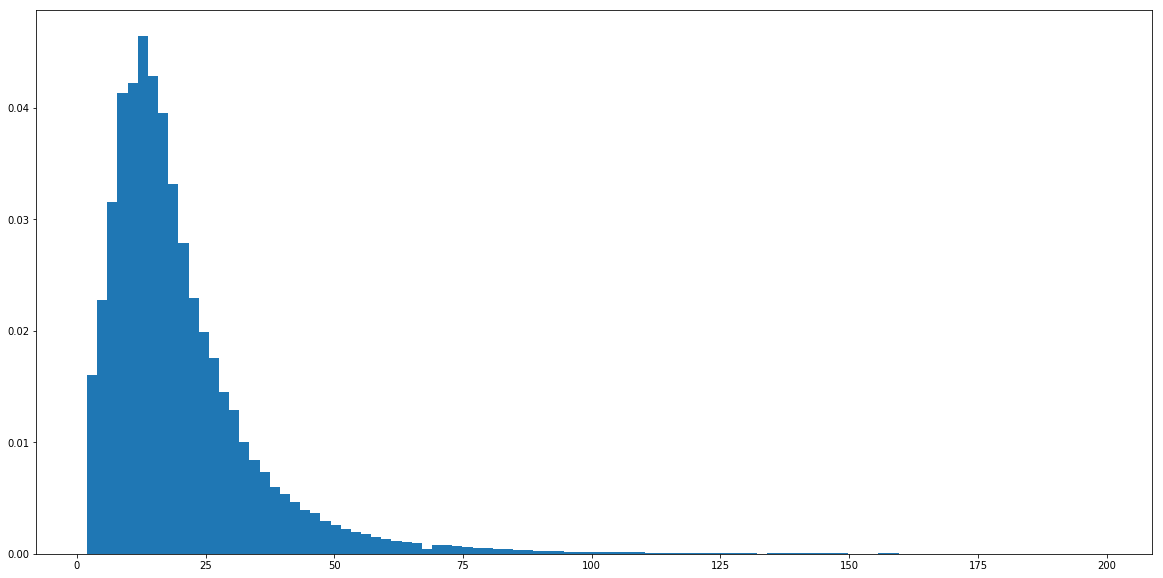

In [8]:
plt.figure(figsize=(20,10))
plt.hist([s for s in s_len if s<200], bins=100, normed=True) #[s for s in s_len if s<200]
#plt.yscale('log', nonposy='clip')
plt.show()

In [9]:
s_len_c = df_c['sentence'].apply(lambda s:len(s.split()))
s_len_nc = df_nc['sentence'].apply(lambda s:len(s.split()))

In [10]:
def hist_len(s_len):
    plt.figure(figsize=(20,10))
    plt.hist([s for s in s_len if s<200], bins=100, normed=True)
    #plt.yscale('log', nonposy='clip')
    plt.show()

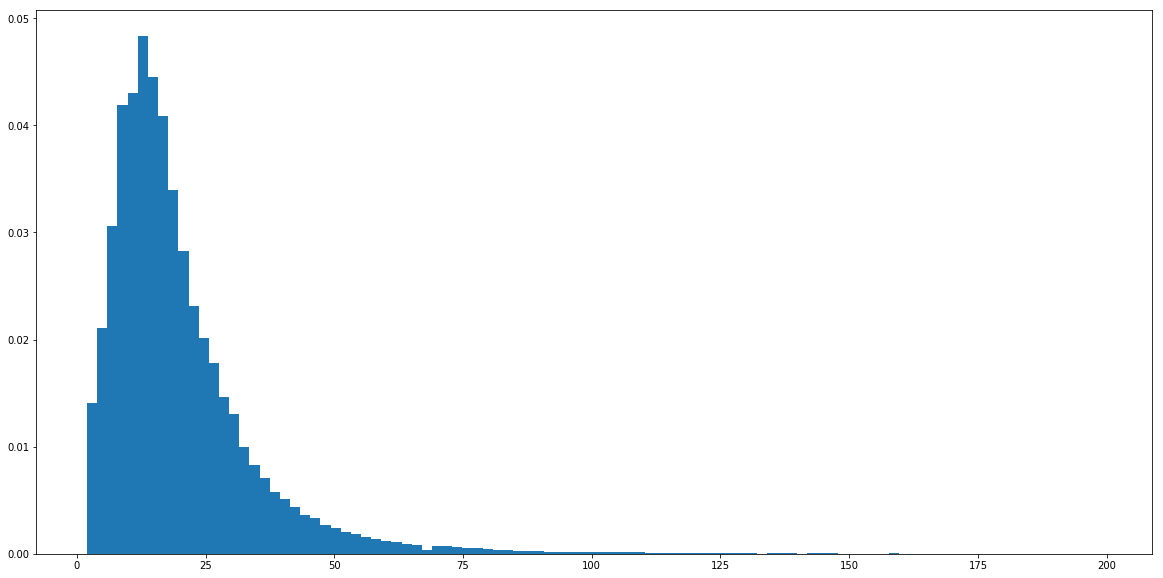

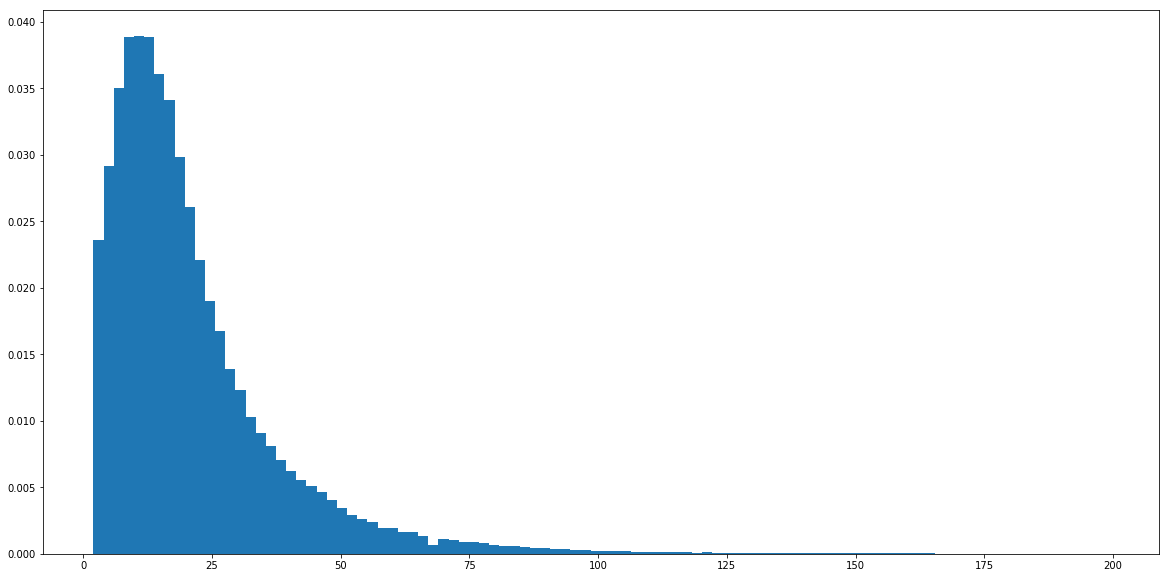

In [11]:
hist_len(s_len_c)
hist_len(s_len_nc)

## Distribuzione numero linee per file

In [12]:
lines_per_file = df[['filename','sentence']].groupby(['filename']).size()

In [13]:
print_column_stats(lines_per_file)

Mean 81.3294374475
Stddev 85.1760234049
Min 1
Max 1172


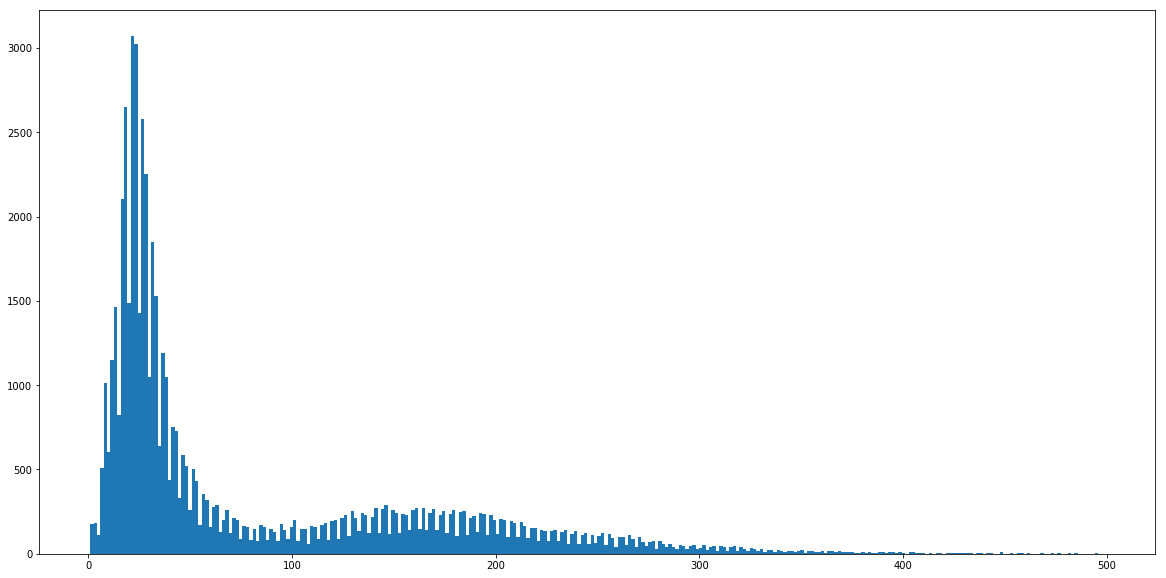

In [14]:
plt.figure(figsize=(20,10))
plt.hist([l for l in lines_per_file if l<500], bins=300)
#plt.yscale('log', nonposy='clip')
plt.show()

In [15]:
lines_per_file_nc = df_nc[['filename','sentence']].groupby(['filename']).size()
lines_per_file_c = df_c[['filename','sentence']].groupby(['filename']).size()

In [16]:
print_column_stats(lines_per_file_c)
print_column_stats(lines_per_file_nc)

Mean 95.2873114989
Stddev 91.4655203665
Min 1
Max 1172
Mean 51.6162454684
Stddev 59.9379149577
Min 1
Max 934


In [17]:
def hist_lines(lines):
    plt.figure(figsize=(20,10))
    plt.hist([l for l in lines if l<300], bins=300)
    #plt.yscale('log', nonposy='clip')
    plt.show()

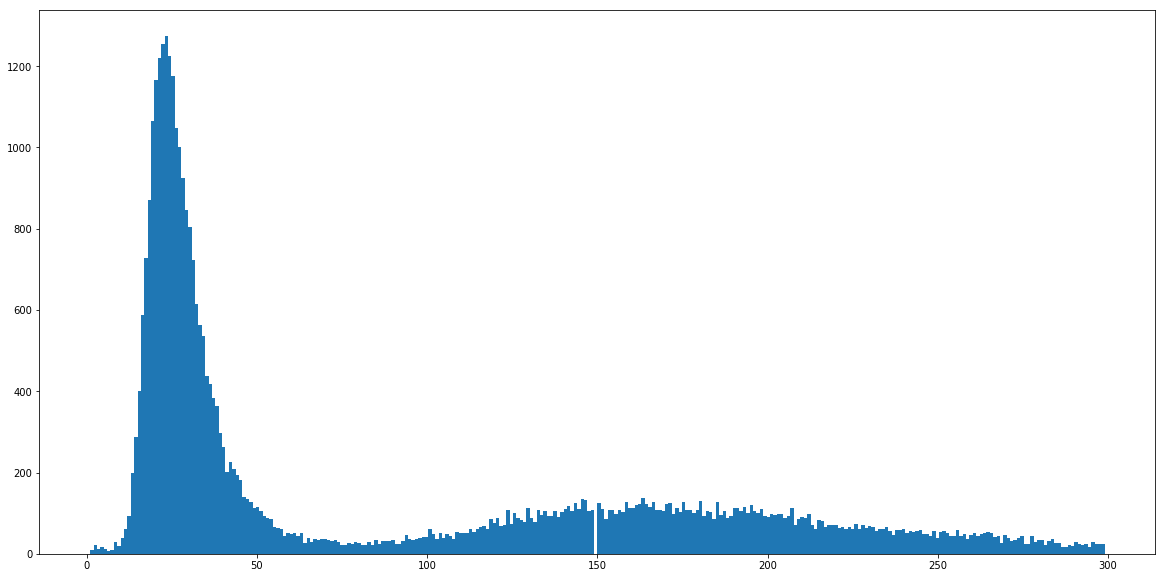

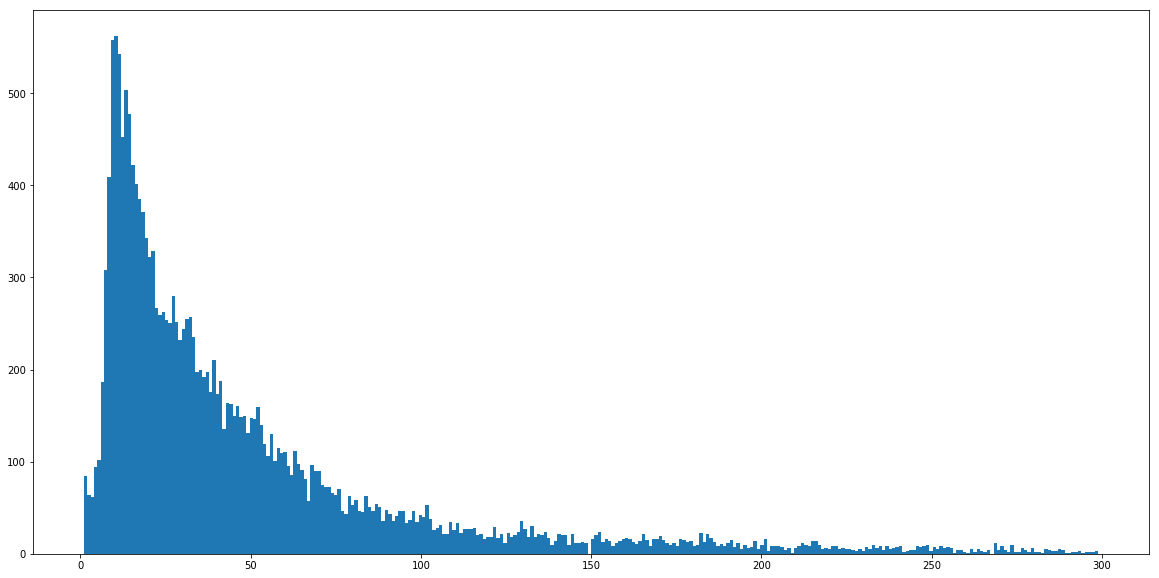

In [18]:
hist_lines(lines_per_file_c)
hist_lines(lines_per_file_nc)

## NLTK test

In [3]:
'''
import nltk
import re
from nltk.tokenize import WordPunctTokenizer
#tokenizer = nltk.data.load('tokenizers/punkt/italian.pickle')
word_tokenizer = WordPunctTokenizer()
from nltk.corpus import stopwords
stop_words = set(stopwords.words('italian'))
import string
punctuation = set(string.punctuation)
'''
from lib.words import allowed_lower_chars, tokenize_doc, read_codec_file, replace_evil_dots_and_underscores, contains_not_allowed_chars, replace_alnum, replace_num

In [8]:
s = u'''ciao\n\n\n. eravamo in sei come va? questa è una super S.P.A. frase ART. perché affronterà;
allorchè poichè finchè èèèòòèòè beusjd fjkdhs §§§ 1 1223. molto  bene\n ciao\n muahah\n\n.'''

#for s in tokenize_doc(s,1):
 #   for w in s:
  #      print w

#print replace_evil_dots_and_underscores(s)
#print [l for l in u'fhdjkflasdààò fdàsaòùàòììì' if l in allowed_lower_chars]
print contains_not_allowed_chars(u'fhdjkflasdààòfdàsaòùàòììì')


for s in tokenize_doc(s, min_words=1):
    print u' '.join(s)

False
ciao
va
super spa frase art affronterà
allorchè poichè finchè èèèòòèòè beusjd fjkdhs 1 NUM molto bene ciao muahah


In [9]:
sents =  tokenize_doc(read_codec_file('../atti_costitutivi_txt/4957502190001.txt'), min_words=2)
for s in sents:
    print ' '.join(s)


n NUM repertorio n NUM raccolta atto costitutivo di societa a responsabilita limitata repubblica italiana l otto marzo duemiladiciassette
in caserta corso trieste n NUM innanzi me avv onofrio caprio notaio orta atella studio ivi via fabrizio de andrè n NUM iscritto ruolo distretto notarile santa maria capua vetere intervengono 1 guarro gennaro nato torre greco na 8 maggio NUM domiciliato caserta frazione tredici via i ottobre n 4 codice fiscale grr gnr ALPHANUM ALPHANUM
2 guarro ernesto nato torre greco na 7 dicembre NUM domiciliato caserta via perlasca n NUM codice fiscale grr rst ALPHANUM ALPHANUM
3 ferracane emanuela nata napoli 5 marzo NUM domiciliata caserta frazione tredici via i ottobre n 4 codice fiscale frr mnl ALPHANUM ALPHANUM
4 lubrano giunno maria rosaria nata napoli NUM giugno NUM domiciliata caserta via perlasca n NUM codice fiscale lbr mrs ALPHANUM ALPHANUM dell identità personale costituiti cittadini italiani notaio certo
articolo 1 i comparenti guarro gennaro guarro e

In [69]:
import nltk
import re
from nltk.tokenize import WordPunctTokenizer
import codecs
import json
import string
from lib import embedding as em
from nltk.corpus import stopwords
from lib.words import replace_evil_dots_and_underscores, splitted_words_utf8, replace_alnum, replace_num, clean_string_not_compressed
stop_words = set(stopwords.words('italian'))
punctuation = set(string.punctuation)
import operator

In [112]:
def index_matches(regex, lines):
    matches = (re.findall(regex, l) for l in lines)
    filt_matches = [(i,int(m[0])) for i,m in enumerate(matches) if m]
    return filt_matches

def changes_only_iter(l, key_fn = lambda x:x):
    il = iter(l)
    t = next(il)
    yield t
    for i in il:
        if key_fn(i)!=key_fn(t):
            t = i
            yield i


In [176]:
#text = codecs.open('../atti_costitutivi_txt/4957502190001.txt', encoding="utf-8").read()
text = codecs.open('../statuti/molesti/4909480860001.txt', encoding="utf-8").read()
#text = codecs.open('../statuti/molesti/4908140980001.txt', encoding="utf-8").read()

In [177]:
lines = [l.strip() for l in text.split('\n') if len(l.strip())>0]

In [178]:
list(enumerate(lines))

[(0, u'REPERTORIO N. 31.472'),
 (1, u'RACCOLTA N. 10.021'),
 (2, u"ATTO COSTITUTIVO DI SOCIETA' A RESPONSABILITA' LIMITATA"),
 (3, u'REPUBBLICA ITALIANA'),
 (4, u"L'anno duemiladiciassette, il giorno sei del mese di febbraio,"),
 (5, u'in Reggio Emilia, in via B. Barilli n. 5/A,'),
 (6,
  u'davanti a me dottoressa Elena Covri, Notaio in Fabbrico, iscritta nel ruolo del Distretto Notarile di Reggio Emilia,'),
 (7, u'sono presenti i signori:'),
 (8, u'GIBERTINI ILIC FAUSTO, nato a Zurigo (Svizzera) il 3 maggio'),
 (9, u'1965, residente a Reggio Emilia, localit\xe0 Codemondo, in via'),
 (10, u'Achille Grimaldi n. 17/2 (codice fiscale: GBR LFS 65E03'),
 (11, u'Z133H);'),
 (12,
  u"FERRARI NICOLO', nato a Reggio Emilia il 5 novembre 1991, residente a San Martino in Rio (Reggio Emilia), in via G. Rossa"),
 (13, u'n. 7 (codice fiscale: FRR NCL 91S05 H223F);'),
 (14, u'comparenti, cittadini italiani, della cui identit\xe0 personale'),
 (15,
  u'io Notaio sono certo, i quali mi hanno dichiarato

In [179]:
num_regex = r'^(\d{1,2})[\.\)](?!\d)'
filt_matches = index_matches(num_regex, lines)
num_matches = list(changes_only_iter(filt_matches, operator.itemgetter(1)))

In [180]:
art_regex = r'(?i)^(?:- )?art\D{0,10}(\d{1,2})'
im = index_matches(art_regex, lines)
im 

matches = sorted(num_matches+im, key=operator.itemgetter(0))

In [182]:
def end_statuto(lines, matches):
    found = False
    if len(matches) == 0:
        return ''
    im = iter(matches)
    _, t = next(im)
    for i, n in im:
        if found == True and n < t:
            return lines[i]
        if n < t:
            #print(n)
            found = True
        t = n
    return ''
        

In [183]:
end_statuto(lines, matches)

u'ARTICOLO 9'